# Sentiment classification




In [0]:
#Importing the dataset in pandas dataframe
import pandas as pd

data = pd.read_csv('/content/Reviews.csv', sep = ',', engine='python')

In [0]:
data.shape

(568454, 10)

In [0]:
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
#Task is to classify sentiments of text so keeping only the text data and rating for classification
data = data[['Text', 'Score']].dropna()

Amazon Food Review uses five-star rating system. Counting the reviews by their score.

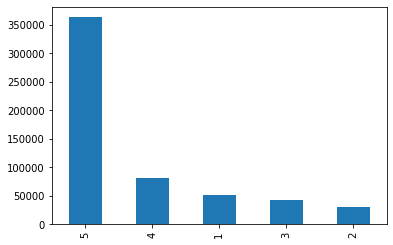

In [0]:
import matplotlib.pyplot as plt

score_count = data['Score'].value_counts()
plot = score_count.plot(kind='bar')

There are much more reviews with rating 5. To avoid using a biased dataset and to balanced it, considering rating 4 and 5 as positive class and 1, 2, and 3 as negative class.

In [0]:
data['Score'][data['Score'] <= 3]= str('Neg')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
data['Score'][data['Score'] != 'Neg']= str('Pos')

In [0]:
#checing the columns in dataset
data.head(5)

,Text,Score
0,I have bought several of the Vitality canned d...,Pos
1,Product arrived labeled as Jumbo Salted Peanut...,Neg
2,This is a confection that has been around a fe...,Pos
3,If you are looking for the secret ingredient i...,Neg
4,Great taffy at a great price. There was a wid...,Pos


In [0]:
#separating positive and negative reviews 
data_pos = data[data['Score'] == 'Pos']
data_neg = data[data['Score'] == 'Neg']

In [0]:
data_neg.shape

(124677, 2)

In [0]:
data_pos.shape

(443777, 2)

Positive review dataset has more than 2 times the reviews in negative dataset. To avoid bias, reducing the number of datapoints in positive dataset equal to the datapoints in negative dataset.

In [0]:
import numpy as np
from sklearn.utils import shuffle
#shuffling data to select reviews at random
data_pos = shuffle(data_pos)
data_pos = data_pos[:len(data_neg)]

In [0]:
data_pos.shape

(124677, 2)

In [0]:
#Splitting positive class into train and test set
from sklearn.model_selection import train_test_split
data_pos_train, data_pos_test = train_test_split(data_pos, test_size = 0.3, random_state = 1)

In [0]:
#Splitting negative class into train and test set
data_neg_train, data_neg_test = train_test_split(data_neg, test_size = 0.3, random_state = 1)

In [0]:
#Creating training dataframe
traindf = pd.concat([data_pos_train, data_neg_train])
traindf = shuffle(traindf)
traindf = traindf.reset_index(drop=True)

In [0]:
#creating testing dataframe
testdf = pd.concat([data_pos_test, data_neg_test])
testdf = shuffle(testdf)
testdf = testdf.reset_index(drop=True)

# 1. Tf-idf + Random Forest

Importing necessary libraries for TfIdf algorithm

In [0]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
#from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
import string
#import re
import spacy
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en import English
spacy.load('en')
parser = English()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining methods to be used for cleaning the text to be used for classification. Removing stopwords and punctuations. Tokenizing and Lemmatizing the words in the text to bring words having different forms but same meaning to their base forms. This is important as it helps reduce redundancy of words.

In [0]:
#Stop words and spcecial characters 
StopWords = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)) 
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","''"]

#lemmatizer = WordNetLemmatizer()

def tokenizer(text):
  text = text.strip().replace("\n", " ").replace("\r", " ")
  text = text.lower()
  tokens = parser(text)
  lemmas = []
  for tok in tokens:
      lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
  tokens = lemmas
  tokens = nltk.tokenize.word_tokenize(text)
  tokens = [tok for tok in tokens if len(tok) > 2]
  #tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
  tokens = [tok for tok in tokens if tok not in StopWords]
  tokens = [tok for tok in tokens if tok not in SYMBOLS]
  tokens = list(set(tokens))

  return ' '.join(tokens[:])

In [0]:
traindf['Text'] = traindf['Text'].apply(lambda x:tokenizer(x))
testdf['Text'] = testdf['Text'].apply(lambda x:tokenizer(x))

In [0]:
y_train = traindf['Score']
x_train = traindf['Text']

y_test = testdf['Score']
x_test = testdf['Text']

TfidfTransformer uses CountVentorizer to count the number of words (term frequency). Training tfidf and evaluating the model on unseen data. TfidfVectorizer also works similar to tfidfTransformer although, it does certain operations all at once. The main difference between the two is that TfidfTransformer will perform step-by-step task of calculating the word count with CountVextorizer, IDF values and Tf-idf scores. Whereas, Tfidfvectorizer will do all these steps in 1 step.

In [0]:
#tfidftransformer - CountVectorizer
count_vect = CountVectorizer(analyzer = 'word', token_pattern=r'\w{1,}')
count_vect.fit(x_train)
xtrain_count = count_vect.transform(x_train)
xtest_count = count_vect.transform(x_test)

In [0]:
#tfidfvectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(x_train)
xtrain_tfidf = tfidf_vect.transform(x_train)
xtest_tfidf = tfidf_vect.transform(x_test)

Using Tf-idf model with classical statistical model, Random Forest.

In [0]:
def training_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    #Fitting the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    #Predicting the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, y_test)

In [0]:
from sklearn import decomposition, ensemble
from sklearn import model_selection, preprocessing, metrics
#RF on Count Vectors
accuracy = training_model(ensemble.RandomForestClassifier(n_estimators=8), xtrain_count, y_train, xtest_count)

print("RF accuracy score, Count Vectors: ", accuracy)

#RF on Word Level TF IDF Vectors
accuracy = training_model(ensemble.RandomForestClassifier(n_estimators=8), xtrain_tfidf, y_train, xtest_tfidf)
print("RF accuracy score, WordLevel TF-IDF: ", accuracy)

RF accuracy score, Count Vectors:  0.8268768046198267
RF accuracy score, WordLevel TF-IDF:  0.8361271521762378


The accuracy score are very close to each other for tfidfVectorizer and tfidftransformer. If computation of tfidf needs to be done on documents other than the training dataset, either of the two modules can be used.

# 2. LSTM Text Classification Model

In [0]:
import tensorflow as tf
import os
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
#from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
#Using the positive and negative datasets together

review_text = pd.concat([data_pos['Text'], data_neg['Text']])
review_label = pd.concat([data_pos['Score'], data_neg['Score']])

In [0]:
#Tokenizing the dataset
#Max no. of words to use
max_words = 50000
#Max no. of words in each review
max_features = 250
#defining tokenizer
review_text = shuffle(review_text)
token = Tokenizer(num_words=max_words, split = ' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)
token.fit_on_texts(review_text)
word_index = token.word_index
print(len(word_index))
Int = token.texts_to_sequences(review_text.values)
Int = sequence.pad_sequences(Int, maxlen=max_features)
Int.shape

92881


(249354, 250)

In [0]:
review_label = shuffle(review_label)
Out = pd.get_dummies(review_label).values
Out.shape

(249354, 2)

In [0]:
#splitting data
Int_train, Int_test, Out_train, Out_test = train_test_split(Int, Out, test_size=0.2, random_state=None)

In [0]:
#Hyperparameters
batch_size = 64
embedding_dims = 100
lstm = 128
input_length = Int.shape[1]

tf.compat.v1.get_default_graph

<function tensorflow.python.framework.ops.get_default_graph>

In [0]:
#LSTM model

model = Sequential()
model.add(Embedding(max_words, embedding_dims, input_length=input_length))
model.add(LSTM(lstm, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2 ,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 5,117,506
Trainable params: 5,117,506
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Loss
loss = 'binary_crossentropy' 
# Optimizer
optimizer = 'adam' 
# Compilation
#############
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [0]:
#Training model
model.fit(Int_train, Out_train, epochs=5, batch_size=batch_size, validation_split=0.1)

Epoch 1/5
2806/2806 [==============================] - 2588s 922ms/step - loss: 0.6933 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 2/5
2806/2806 [==============================] - 2570s 916ms/step - loss: 0.6909 - accuracy: 0.5283 - val_loss: 0.6958 - val_accuracy: 0.4978
Epoch 3/5
2806/2806 [==============================] - 2562s 913ms/step - loss: 0.6788 - accuracy: 0.5635 - val_loss: 0.7085 - val_accuracy: 0.4931
Epoch 4/5
2806/2806 [==============================] - 2645s 942ms/step - loss: 0.6530 - accuracy: 0.6016 - val_loss: 0.7350 - val_accuracy: 0.4958
Epoch 5/5
2806/2806 [==============================] - 2660s 948ms/step - loss: 0.6200 - accuracy: 0.6347 - val_loss: 0.7644 - val_accuracy: 0.4953


val_loss is increasing with each incrementing epoch. The number of learning parameters can be reduced here as because of too many learning parameters, model is learning the examples and so not working well with test/validation data. 

In [0]:
test_score = model.evaluate(Int_test, Out_test, verbose=0)
print('Test accuracy:', test_score[1])

Test accuracy: 0.4966012239456177


There are less number of examples in the test dataset. The model performs poorly on test data as compared to training data. The model has high variance and seems to be overfitting.

# 3. LSTM Model: where the embeddings are initialized with pre-trained GloVe vectors

In [0]:
#Creating directory for storing pre-processed data
if(not os.path.isdir('preprocessed_data')):
    os.mkdir('preprocessed_data')

In [0]:
import io
from keras.initializers import Constant
from keras.utils import to_categorical

In [0]:
#Downloading pre-trained GloVe Vectors

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls
!pwd

--2020-05-30 15:24:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-05-30 15:24:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-05-30 15:24:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [0]:
base_dir = '/content/'
glove_dir = os.path.join(base_dir)

In [0]:
#Building the index mapping words in the embeddings set to their respective embedding vector

embedding_index = {}
with open(os.path.join(glove_dir, 'glove.6B.300d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embedding_index[word] = coefs

print('Found %s word vectors.' % len(embedding_index))
#print(len(embedding_index))

Found 400000 word vectors.


In [0]:
MAX_SEQ_LENGTH = 50 #max length of each sentence
MAX_WORDS = 150000 #max no. of words for tokenizer
EMBEDDING_DIM = 300 #wmbedding dimensions for word vectors (GloVe)
LSTM_SIZE = 300

In [0]:
#Tokenizing the dataset
max_features = 100
tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(review_text)
X_gl = tokenizer.texts_to_sequences(review_text.values)
X_gl = sequence.pad_sequences(X_gl, maxlen=max_features)
review_label = shuffle(review_label)
Y_gl = pd.get_dummies(review_label).values

In [0]:
#Vectorizing the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(review_text)
sequences = tokenizer.texts_to_sequences(review_text.values)

word_idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word_idx))

data = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH)

#labels = to_categorical(np.asarray(review_label))
labels = np.asarray(pd.get_dummies(review_label))
print('Data tensor shape:', data.shape)
print('Label tensor shape:', labels.shape)

Found 93000 unique tokens.
Data tensor shape: (249354, 50)
Label tensor shape: (249354, 2)


In [0]:
#creating a weight matrix
num_words = min(MAX_WORDS, len(word_idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_idx.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
# Data split into training  and test set 
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(0.2 * data.shape[0])

x_train_gl = data[:-num_validation_samples]
y_train_gl = labels[:-num_validation_samples]
x_test_gl = data[-num_validation_samples:]
y_test_gl = labels[-num_validation_samples:]

In [0]:
#Embedding Layer
embedding_layer = Embedding(input_dim=len(word_idx) + 1,
                                output_dim=EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQ_LENGTH,
                                trainable=True)

In [0]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(LSTM_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           27900300  
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 2)                 602       
Total params: 28,622,102
Trainable params: 28,622,102
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Loss
loss = 'binary_crossentropy' 
#Optimizer
optimizer = 'nadam' 
#Model Compilation
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [0]:
#Fitting model
model.fit(x_train_gl, y_train_gl,validation_split=0.2,batch_size=120,epochs=5)

Train on 159587 samples, validate on 39897 samples
Epoch 1/5
159587/159587 [==============================] - 391s 2ms/sample - loss: 0.6953 - accuracy: 0.5007 - val_loss: 0.6936 - val_accuracy: 0.5006
Epoch 2/5
159587/159587 [==============================] - 385s 2ms/sample - loss: 0.6916 - accuracy: 0.5179 - val_loss: 0.6948 - val_accuracy: 0.5036
Epoch 3/5
159587/159587 [==============================] - 386s 2ms/sample - loss: 0.6828 - accuracy: 0.5477 - val_loss: 0.6999 - val_accuracy: 0.5011
Epoch 4/5
159587/159587 [==============================] - 384s 2ms/sample - loss: 0.6628 - accuracy: 0.5804 - val_loss: 0.7183 - val_accuracy: 0.4987
Epoch 5/5
159587/159587 [==============================] - 383s 2ms/sample - loss: 0.6347 - accuracy: 0.6144 - val_loss: 0.7519 - val_accuracy: 0.5010


There is a slight improvement in model performance with pretrained GloVe vectors with introduction of weights.

In [0]:
scores = model.evaluate(x_test_gl, y_test_gl, verbose=0)
print('Test Accuracy:' , scores[1])

Test Accuracy: 0.50382996


There are less number of examples in the test dataset. The model performs poorly on test data as compared to training data. The model has high variance and seems to be overfitting.

# 4. fastText

In [0]:
!pip install ktrain

In [0]:
!pip install fasttext

In [0]:
import ktrain
from ktrain import text
#%tensorflow_version 2.x
import tensorflow as tf

In [0]:
import pandas as pd
from sklearn.utils import shuffle

df = pd.read_csv('/content/Reviews.csv', sep = ',', engine='python')
df = shuffle(df)
df = df[:75000]
df = df[['Text', 'Score']]
df['Score'] = df['Score'].apply(lambda x: 'neg' if x <= 3 else 'pos')
df.columns = ['text', 'label']
df.head(5)

In [0]:
df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)
df.head(5)


In [0]:
df = df.drop(columns='label')
df = df[['text', 'neg', 'pos']]

In [0]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 'text', label_columns=['neg', 'pos'],
                                                                  maxlen=75, max_features=100000,
                                                                  preprocess_mode='standard', val_pct=0.1,
                                                                  ngram_range=3)

In [0]:
text.print_text_classifiers()

In [0]:
model = text.text_classifier('fasttext', (x_train, y_train), preproc=preproc)

In [0]:
learner_mod = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

In [0]:
#Learning rate finder
learner_mod.lr_find()

In [0]:
#Learning rate plot
learner_mod.lr_plot()

In [0]:
learner_mod.autofit(0.0009, 10)

In [0]:
predicting = ktrain.get_predictor(learner_mod.model, preproc)

In [0]:
data = [ 'It was a boring movie! What a waste of money.',
         'What an amazing piece of art. I would see the movie again.',
        'What a beautiful romantic comedy.']

In [0]:
predicting.predict(data)

# 5. BERT Model

In [0]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df, 'text', label_columns=['neg', 'pos'],
                                                                      maxlen = 550,
                                                                      preprocess_mode='bert')

In [0]:
learner_ktrain = ktrain.get_learner(text.text_classifier('bert',(x_train,y_train),preproc=preproc),
                                                train_data=(x_train,y_train),
                                                val_data=(x_test, y_test),
                                                batch_size=3)

In [0]:
learner_ktrain.lr_find()
learner_ktrain.lr_plot()

In [0]:
learner_ktrain.fit_onecycle(2e-5, 3)

In [0]:
predicting = ktrain.get_predictor(learner_mod.model, preproc)

In [0]:
data = [ 'It was a boring movie! What a waste of money.',
         'What an amazing piece of art. I would see the movie again.',
        'What a beautiful romantic comedy.']

In [0]:
predicting.predict(data)